In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [6]:
data = pd.read_csv("daily-min-temperatures.csv")
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
lag = 3 #  we are making a AR(3) model, thus the lag is kept as 3

for i in range(1, lag + 1):
    data[f"lag_{i}"] = data["Temp"].shift(i)

data = data.dropna().reset_index(drop=True) # removed all NaN rows
data.head()


,Date,Temp,lag_1,lag_2,lag_3
0,1981-01-07,15.8,15.8,15.8,14.6
1,1981-01-08,17.4,15.8,15.8,15.8
2,1981-01-09,21.8,17.4,15.8,15.8
3,1981-01-10,20.0,21.8,17.4,15.8
4,1981-01-11,16.2,20.0,21.8,17.4


In [19]:
split_ratio = 0.8

train_size = int(len(data)*split_ratio)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

X_train = torch.tensor(train[[f"lag_{i}" for i in range(1,lag+1)]].values, dtype = torch.float32)
y_train = torch.tensor(train["Temp"].values, dtype = torch.float32).view(-1,1)

X_test = torch.tensor(train[[f"lag_{i}" for i in range(1,lag+1)]].values, dtype = torch.float32)
y_test = torch.tensor(train["Temp"].values, dtype = torch.float32).view(-1,1)

pd.DataFrame(X_train).head()



,0,1,2
0,15.800000,15.800000,14.6
1,15.800000,15.800000,15.8
2,17.400000,15.800000,15.8
3,21.799999,17.400000,15.8
4,20.000000,21.799999,17.4


In [21]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.linear(x)


In [22]:
model = LinearRegressionModel(lag)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [23]:
num_epochs = 200
losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [20/200], Loss: 8.5909
Epoch [40/200], Loss: 7.9419
Epoch [60/200], Loss: 7.4778
Epoch [80/200], Loss: 7.1551
Epoch [100/200], Loss: 6.9499
Epoch [120/200], Loss: 6.8244
Epoch [140/200], Loss: 6.7474
Epoch [160/200], Loss: 6.6985
Epoch [180/200], Loss: 6.6664
Epoch [200/200], Loss: 6.6445


In [24]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)


In [25]:
rmse = torch.sqrt(criterion(y_pred_test, y_test))
print(f"\nRMSE: {rmse.item():.3f}")



RMSE: 2.578


ValueError: x and y must have same first dimension, but have shapes (729,) and (2915, 1)

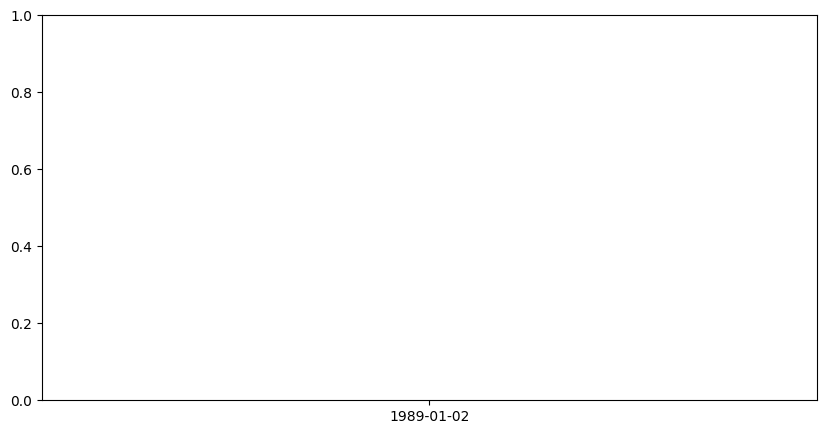

In [26]:
plt.figure(figsize=(10,5))
plt.plot(test['Date'], y_test.numpy(), label='True Temperature', linewidth=2)
plt.plot(test['Date'], y_pred_test.numpy(), label='Predicted Temperature', linestyle='dashed', color='red')
plt.title("Autoregressive Forecasting using PyTorch Linear Regression")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()
